<a href="https://colab.research.google.com/github/workdd/MLOps_with_MLFlow/blob/main/mlflow_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLFlow를 활용한 MLOps 챕터4

# TensorFlow 2.0을 사용한 MLFlow(Keras) (p161)

## 필수 라이브러리 설치 및 버전 확인

In [1]:
!pip install mlflow==1.10.0
#scikit-learn 1.2 버전 아래에서 진행해야 원활히 진행 가능
!pip install scikit-learn==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 69.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.datasets import mnist

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import roc_auc_score

import mlflow
import mlflow.tensorflow

print("Tensorflow: {}".format(tf.__version__))
print("scikit-learn: {}".format(sklearn.__version__))
print("Numpy: {}".format(np.__version__))
print("MLFlow: {}".format(mlflow.__version__))
print("Matplotlib: {}".format(matplotlib.__version__))


Tensorflow: 2.12.0
scikit-learn: 1.1.0
Numpy: 1.22.4
MLFlow: 1.10.0
Matplotlib: 3.7.1


## Databricks 연결

MLFlow Ui 사용을 위해 Databricks에 연결해야 함

In [3]:
!databricks configure --host https://community.cloud.databricks.com/
mlflow.set_tracking_uri("databricks")

databricks_email = "workdofficial@gmail.com"
mlflow_experiment = "TF_Keras_MNIST"

# Databricks에 로그인, experiment가 없을 경우 새로 생성 후 연결
mlflow.set_experiment(f"/Users/{databricks_email}/{mlflow_experiment}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Username: workdofficial@gmail.com
Password: 
Repeat for confirmation: 


11490434/11490434 [==============================] - 1s 0us/step
Class:  5


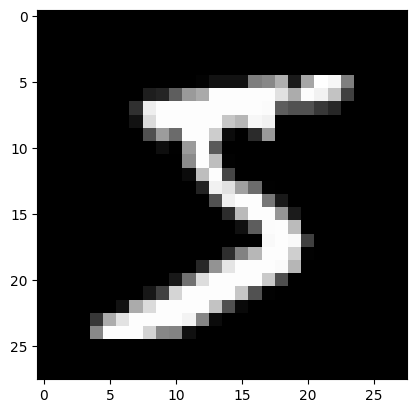

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

plt.imshow(x_train[0], cmap='gray')
print("Class: ", y_train[0])

In [5]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# y label에 대해서 one-hot 인코딩 벡터로 변환
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print(y_test[0])

print("Shapes")
print("x_train: {}\ny_train: {}".format(x_train.shape, y_train.shape))
print("x_test: {}\ny_test: {}".format(x_test.shape, y_test.shape))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Shapes
x_train: (60000, 28, 28, 1)
y_train: (60000, 10)
x_test: (10000, 28, 28, 1)
y_test: (10000, 10)


In [6]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(filters=8, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(30, activation="relu"))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 30)                11790     
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 13,940
Trainable params: 13,940
Non-traina

In [7]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
mlflow.set_experiment(f"/Users/{databricks_email}/{mlflow_experiment}")

with mlflow.start_run():

  # MLFlow에 Tensorflow/Keras 모델과 관련된 파라미터, 지표 기록
  mlflow.tensorflow.autolog()

  model.fit(x=x_train, y=y_train, batch_size=256, epochs=10)
  preds = model.predict(x_test)
  preds = np.round(preds)
  eval_acc = model.evaluate(x_test, y_test)[1]
  auc_score = roc_auc_score(y_test, preds)

  print("eval_acc: ", eval_acc)
  print("auc_score: ", auc_score)

  mlflow.tensorflow.mlflow.log_metric("eval_acc", eval_acc)
  mlflow.tensorflow.mlflow.log_metric("auc_score", auc_score)

mlflow.end_run()


/usr/local/lib/python3.10/dist-packages/mlflow/tensorflow.py:753: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(tensorflow.__version__) < LooseVersion('1.12'):


Epoch 1/10
235/235 [==============================] - 10s 34ms/step - loss: 1.3414 - accuracy: 0.5838
Epoch 2/10
235/235 [==============================] - 9s 36ms/step - loss: 0.2676 - accuracy: 0.9198
Epoch 3/10
235/235 [==============================] - 9s 38ms/step - loss: 0.1666 - accuracy: 0.9502
Epoch 4/10
235/235 [==============================] - 7s 29ms/step - loss: 0.1269 - accuracy: 0.9622
Epoch 5/10
235/235 [==============================] - 10s 43ms/step - loss: 0.1039 - accuracy: 0.9682
Epoch 6/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0892 - accuracy: 0.9726
Epoch 7/10
235/235 [==============================] - 10s 42ms/step - loss: 0.0756 - accuracy: 0.9771
Epoch 8/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0662 - accuracy: 0.9799
Epoch 9/10
235/235 [==============================] - 9s 38ms/step - loss: 0.0584 - accuracy: 0.9813
Epoch 10/10
235/235 [==============================] - 7s 29ms/step - loss: 0.0532 - acc

/usr/local/lib/python3.10/dist-packages/mlflow/keras.py:68: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(tf.__version__) <= LooseVersion('1.13.2'):


313/313 [==============================] - 2s 5ms/step - loss: 0.0818 - accuracy: 0.9753
eval_acc:  0.9753000140190125
auc_score:  0.9854398220360414


# MLFlow UI에서 로그 확인, 모델 적재

In [10]:
# MLFlow UI에서 생성된 실행 ID 확인 후 기입
RUN_ID = "<Your RUN ID>"
# 실행 ID를 통해 실행된 모델을 불러올 수 있다
loaded_model = mlflow.keras.load_model(f"runs:/{RUN_ID}/model")

/usr/local/lib/python3.10/dist-packages/mlflow/keras.py:352: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if StrictVersion(keras_module.__version__.split('-')[0]) >= StrictVersion("2.2.3"):


In [11]:
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)
preds = loaded_model.predict(x_test)
preds = np.round(preds)

eval_auc = roc_auc_score(y_test, preds)

print("Eval Loss:", eval_loss)
print("Eval Acc:", eval_acc)
print("Eval AUC:", eval_auc)

313/313 [==============================] - 1s 3ms/step
Eval Loss: 0.08181002736091614
Eval Acc: 0.9753000140190125
Eval AUC: 0.9854398220360414
